In [1]:
import numpy as np
import gc
import matplotlib.pyplot as plt
import os 
from itertools import islice
%matplotlib inline

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn

## Getting the MNIST Data Set

We have access to a number of now standard datasets via PyTorch directly.  So to get MNIST set up, all we need to do is the following.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image_path = './' # just store everything to your local working directory
mnist_data_path = image_path + '/MNIST'

transform = transforms.Compose([transforms.ToTensor()])

if not os.path.isdir(mnist_data_path): # if you've already downloaded and converted the MNIST images, skip

    # Download and convert MNIST images into tensor format. 
    mnist_dataset = torchvision.datasets.MNIST(image_path, train=True, transform=transform, download=True)
    mnist_dataset_test = torchvision.datasets.MNIST(image_path, train=False, transform=transform, download=True)
     # Sanity check to make sure your download worke
    assert isinstance(mnist_dataset, torch.utils.data.Dataset)

else:
    # Download and convert MNIST images into tensor format. 
    mnist_dataset = torchvision.datasets.MNIST(image_path, train=True, transform=transform, download=False)
    mnist_dataset_test = torchvision.datasets.MNIST(image_path, train=False, transform=transform, download=False)


valid_size = 10000
train_size = len(mnist_dataset) - valid_size
mnist_dataset_valid = Subset(mnist_dataset, torch.arange(valid_size))
mnist_dataset_train = Subset(mnist_dataset, torch.arange(valid_size, len(mnist_dataset)))

cuda


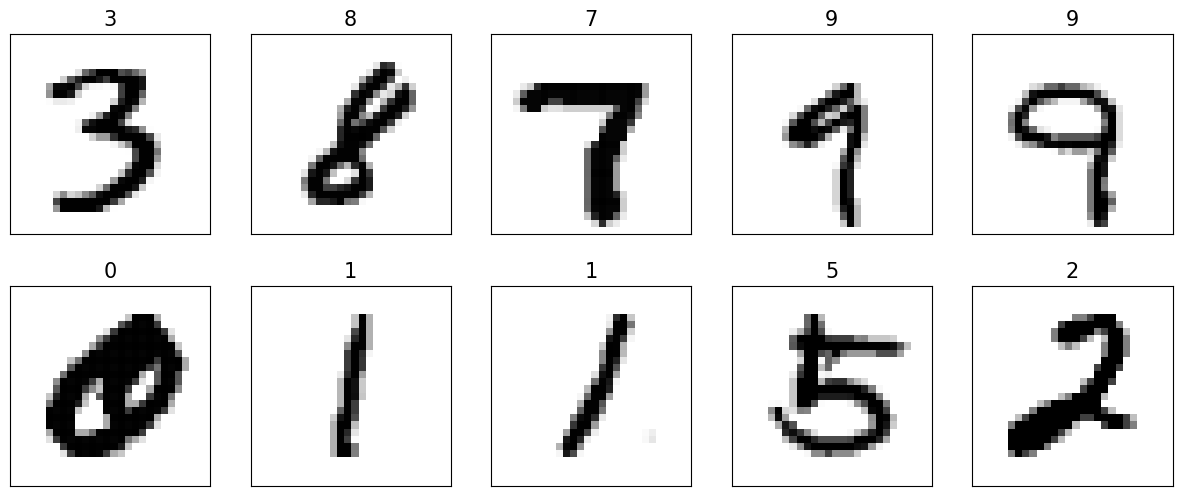

In [3]:
fig = plt.figure(figsize=(15,6))
for ii, (image, label) in islice(enumerate(mnist_dataset_train),10):
    ax = fig.add_subplot(2,5,ii+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torch.squeeze(image,0), cmap='gray_r')
    ax.set_title(f'{label}', size=15)

Here we decide on a batch size for running Stochastic Gradient Descent and then get our training data into the proper format for iterating over epochs with a random shuffle into new batches at every iteration.  

In [4]:
batch_size = 64
torch.manual_seed(1)

pmem = False
if torch.cuda.is_available():
    pmem = True

train_dl = DataLoader(mnist_dataset_train, batch_size=batch_size, shuffle=True, pin_memory=pmem)        
valid_dl = DataLoader(mnist_dataset_valid, batch_size=batch_size, shuffle=False, pin_memory=pmem)
    

## Building the Model

In [5]:
model = nn.Sequential()

# First convoultional/pooling layer
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# Second convoultional/pooling layer
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

# Fully connected classifier label like we had before
model.add_module('flatten', nn.Flatten())

# We need to know how large of a vector our model will produce,
# so we introduce a little hack.

x = torch.ones((4, 1, 28, 28))
dims = model(x).shape

# Now that we know the right sizes to use, we build our 
# connected network with droput before we get to the 
# classifier.

model.add_module('fc1', nn.Linear(dims[1], 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))
model.to(device)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

## Choosing the Loss Function and Optimizer

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training across Epochs

In [14]:
num_epochs = 5

loss_history_train = np.zeros(num_epochs)
accuracy_history_train = np.zeros(num_epochs)
loss_history_valid = np.zeros(num_epochs)
accuracy_history_valid = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train() 
    for x_batch, y_batch in train_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward() # perform backpropagation
        optimizer.step() # optimize over the given batch
        optimizer.zero_grad() # zero out the gradient for the next iteration
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        
        loss_history_train[epoch] += loss.item()*y_batch.size(0)
        accuracy_history_train[epoch] += is_correct.sum()
        
    model.eval() # Note, we need model.train() and model.eval() to manage the dropout layer correctly 
    
    loss_history_train[epoch] /= len(train_dl.dataset)
    accuracy_history_train[epoch] /= len(train_dl.dataset)
    
    # We now look at validation data as we train to get a sense of how generalizable our model is to test data.

    with torch.no_grad(): # don't optimize at this point, i.e. keep all weights fixed 
        for x_batch, y_batch in valid_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            loss_history_valid[epoch] += loss.item()*y_batch.size(0)
            accuracy_history_valid[epoch] += is_correct.sum()
            
    loss_history_valid[epoch] /= len(valid_dl.dataset)
    accuracy_history_valid[epoch] /= len(valid_dl.dataset)
    
    print(f"Epoch {epoch} accuracy: {accuracy_history_train[epoch]:.4f} "
          f"val_accuracy: {accuracy_history_valid[epoch]}")
    
del x_batch
del y_batch
del optimizer
gc.collect()
torch.cuda.empty_cache()

Epoch 0 accuracy: 0.9936 val_accuracy: 0.9889
Epoch 1 accuracy: 0.9955 val_accuracy: 0.9911
Epoch 2 accuracy: 0.9960 val_accuracy: 0.9908
Epoch 3 accuracy: 0.9960 val_accuracy: 0.9881
Epoch 4 accuracy: 0.9972 val_accuracy: 0.9895


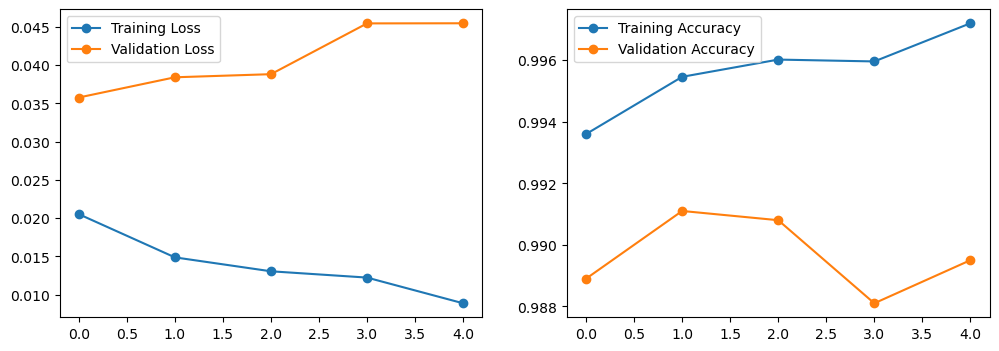

In [15]:
x_arr = np.arange(num_epochs)
fig = plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.plot(x_arr, loss_history_train, '-o', label='Training Loss')
ax.plot(x_arr, loss_history_valid, '-o', label='Validation Loss')
ax.legend()

ax=fig.add_subplot(1,2,2)
ax.plot(x_arr, accuracy_history_train, '-o', label='Training Accuracy')
ax.plot(x_arr, accuracy_history_valid, '-o', label='Validation Accuracy')
ax.legend();

## Testing Our Trained Model 

In [16]:
test_data = mnist_dataset_test.data.to(device)/255.
test_pred = model(test_data.unsqueeze(1))
is_correct = (torch.argmax(test_pred, dim=1) == mnist_dataset_test.targets.to(device) ).float()
print(f'Test Accuracy is: {is_correct.mean():.4f}')

Test Accuracy is: 0.9907
